In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Deep Learning imports
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, Flatten
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    print(" TensorFlow loaded successfully")
except ImportError:
    print(" TensorFlow not available. Please install: pip install tensorflow")
    exit()

print("="*60)
print("JOB MARKET ANALYSIS - LSTM MODEL BUILDING")
print("="*60)

 TensorFlow loaded successfully
JOB MARKET ANALYSIS - LSTM MODEL BUILDING


In [3]:
# Load cleaned data
df = pd.read_csv('/content/cleaned_job_EDA.csv')
df['published_date'] = pd.to_datetime(df['published_date'])
print(f" Loaded data: {df.shape[0]} rows, {df.shape[1]} columns")

 Loaded data: 244656 rows, 30 columns


In [4]:
# TASK 1: TIME SERIES PREDICTION OF JOB POSTINGS
print("\n" + "="*50)
print("TASK 1: JOB POSTING VOLUME PREDICTION")
print("="*50)

# Prepare daily job counts time series
daily_jobs = df.groupby(df['published_date'].dt.date).size().reset_index()
daily_jobs.columns = ['date', 'job_count']
daily_jobs['date'] = pd.to_datetime(daily_jobs['date'])
daily_jobs = daily_jobs.sort_values('date').reset_index(drop=True)

print(f" Time series data: {len(daily_jobs)} days")
print(f" Date range: {daily_jobs['date'].min().date()} to {daily_jobs['date'].max().date()}")
print(f" Average jobs per day: {daily_jobs['job_count'].mean():.1f}")



TASK 1: JOB POSTING VOLUME PREDICTION
 Time series data: 89 days
 Date range: 2023-11-02 to 2024-03-24
 Average jobs per day: 2748.9


In [5]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    """Create sequences for LSTM training"""
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])

    return np.array(sequences), np.array(targets)

# Prepare data for LSTM
seq_length = 7  # Use 7 days to predict next day
scaler = MinMaxScaler()
job_counts_scaled = scaler.fit_transform(daily_jobs[['job_count']])


In [6]:
# Create sequences
X, y = create_sequences(job_counts_scaled.flatten(), seq_length)
print(f"📋 Created {len(X)} sequences of length {seq_length}")

# Split data
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f" Training data: {X_train.shape}")
print(f" Testing data: {X_test.shape}")

📋 Created 82 sequences of length 7
 Training data: (65, 7, 1)
 Testing data: (17, 7, 1)


In [8]:
# Build LSTM Model
print("\n Building LSTM model...")

model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
print(" LSTM model compiled")



 Building LSTM model...
 LSTM model compiled


In [10]:
# Train the model
print("\n Training LSTM model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

history = model_lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print(" LSTM training completed")



 Training LSTM model...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 0.2053 - mae: 0.2922 - val_loss: 0.2384 - val_mae: 0.4581 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0981 - mae: 0.2391 - val_loss: 0.0572 - val_mae: 0.2046 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0572 - mae: 0.2057 - val_loss: 0.0448 - val_mae: 0.1352 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0436 - mae: 0.1825 - val_loss: 0.0423 - val_mae: 0.1320 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0375 - mae: 0.1459 - val_loss: 0.0367 - val_mae: 0.1751 - learning_rate: 0.0010
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0372 - mae: 0.1268 - val_loss: 0.0373 - val_mae: 0.1765 - learning_rate: 0.0010
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0465 - mae: 0.1383 - val_loss: 0.0332 - val_mae: 0.1482 - learning_rate: 0.0010
E

In [11]:
# Make predictions
print("\n Making predictions...")
train_predictions = model_lstm.predict(X_train)
test_predictions = model_lstm.predict(X_test)

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
train_mae = mean_absolute_error(y_train_actual, train_predictions)
test_mae = mean_absolute_error(y_test_actual, test_predictions)

print(f"\n Model Performance:")
print(f"  Training RMSE: {train_rmse:.2f}")
print(f"  Testing RMSE: {test_rmse:.2f}")
print(f"  Training MAE: {train_mae:.2f}")
print(f"  Testing MAE: {test_mae:.2f}")



 Making predictions...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

 Model Performance:
  Training RMSE: 1400.98
  Testing RMSE: 1368.42
  Training MAE: 741.77
  Testing MAE: 1141.78


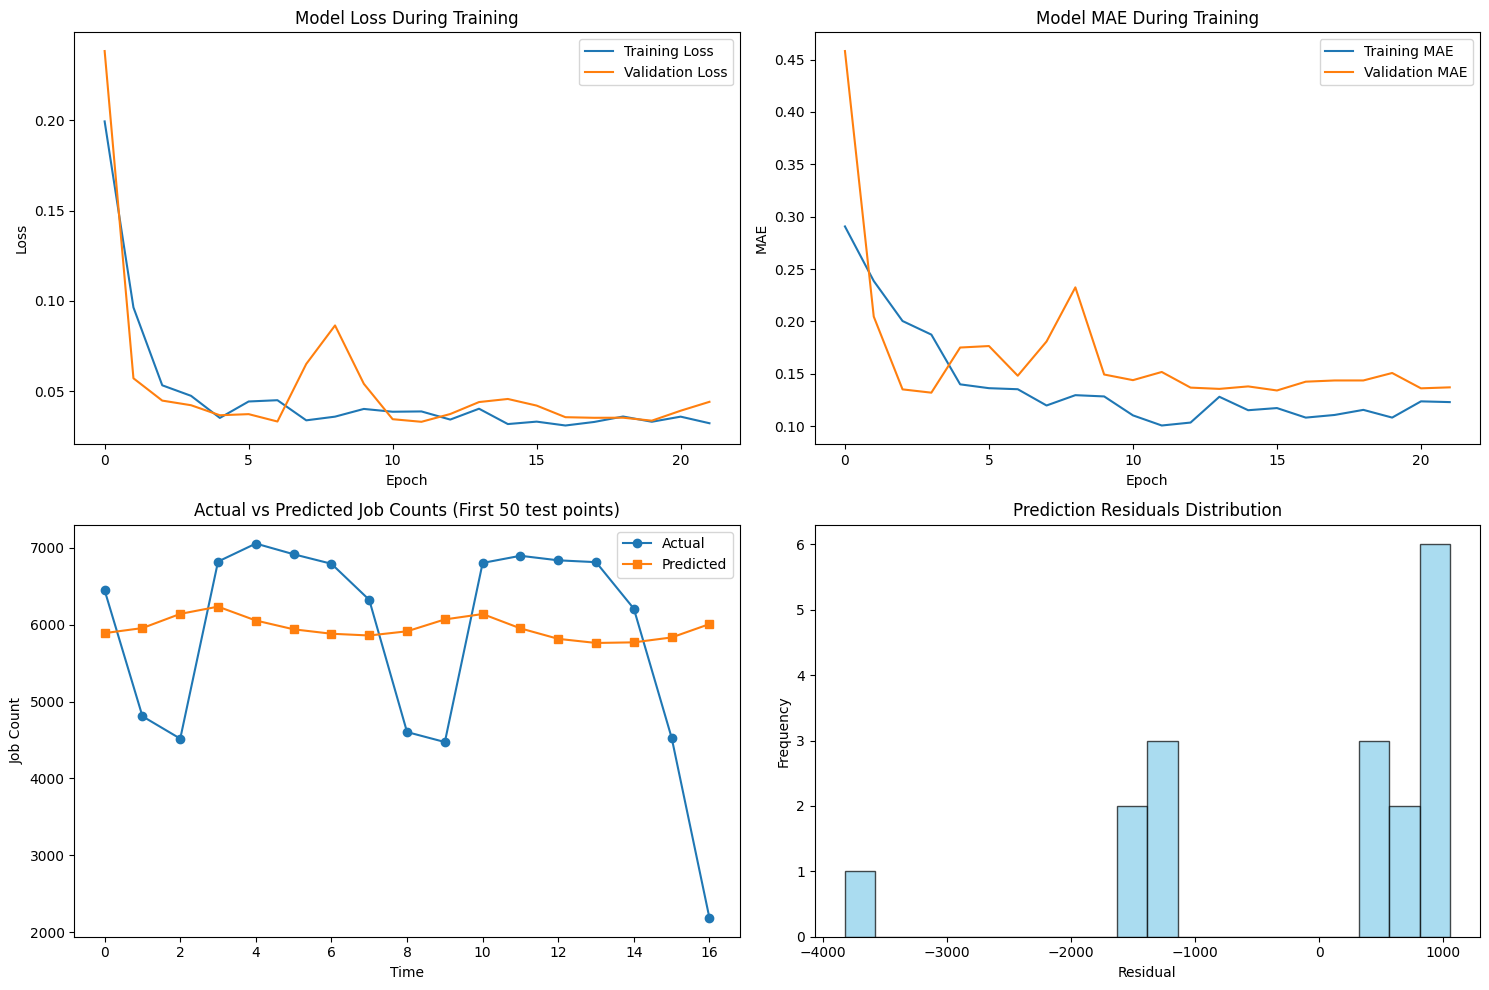

In [12]:
# Visualize results
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test_actual.flatten()[:50], label='Actual', marker='o')
plt.plot(test_predictions.flatten()[:50], label='Predicted', marker='s')
plt.title('Actual vs Predicted Job Counts (First 50 test points)')
plt.xlabel('Time')
plt.ylabel('Job Count')
plt.legend()

plt.subplot(2, 2, 4)
residuals = y_test_actual.flatten() - test_predictions.flatten()
plt.hist(residuals, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Prediction Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('lstm_job_volume_prediction.png', dpi=300, bbox_inches='tight')
plt.show()


In [13]:
# TASK 2: CATEGORY-WISE JOB DEMAND PREDICTION
print("\n" + "="*50)
print("TASK 2: CATEGORY-WISE DEMAND PREDICTION")
print("="*50)

# Prepare category-wise time series data
category_daily = df.groupby([df['published_date'].dt.date, 'job_category']).size().unstack(fill_value=0)
category_daily.index = pd.to_datetime(category_daily.index)
category_daily = category_daily.sort_index()

print(f" Category time series shape: {category_daily.shape}")
print(f" Categories: {list(category_daily.columns)}")





TASK 2: CATEGORY-WISE DEMAND PREDICTION
 Category time series shape: (89, 12)
 Categories: ['Business & Management', 'Customer Support', 'Data & Analytics', 'Design & Creative', 'E-commerce & Retail', 'Finance & Accounting', 'Marketing & Advertising', 'Marketing & Sales', 'Other', 'Sales & Business Development', 'Software Development', 'Writing & Content']


In [15]:
# Build multi-output LSTM for category prediction
print("\n Building multi-output LSTM for categories...")

# Prepare data
seq_length_cat = 5  # Use 5 days to predict next day for each category
scaler_cat = MinMaxScaler()
category_data_scaled = scaler_cat.fit_transform(category_daily.values)

# Create sequences for multiple outputs
def create_multi_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X_cat, y_cat = create_multi_sequences(category_data_scaled, seq_length_cat)

# Split data
split_idx = int(len(X_cat) * 0.8)
X_cat_train, X_cat_test = X_cat[:split_idx], X_cat[split_idx:]
y_cat_train, y_cat_test = y_cat[:split_idx], y_cat[split_idx:]

print(f" Category training data: {X_cat_train.shape}")
print(f" Category testing data: {X_cat_test.shape}")


 Building multi-output LSTM for categories...
 Category training data: (67, 5, 12)
 Category testing data: (17, 5, 12)


In [16]:
# Build multi-output LSTM model
n_features = category_daily.shape[1]

model_multi = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length_cat, n_features)),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(n_features, activation='linear')
])

model_multi.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
print(" Multi-output LSTM model compiled")


 Multi-output LSTM model compiled


In [17]:
# Train multi-output model
print("\n Training multi-output LSTM...")
history_multi = model_multi.fit(
    X_cat_train, y_cat_train,
    epochs=30,
    batch_size=8,
    validation_data=(X_cat_test, y_cat_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


 Training multi-output LSTM...
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.1696 - mae: 0.2184 - val_loss: 0.4015 - val_mae: 0.5906 - learning_rate: 0.0010
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1798 - mae: 0.2685 - val_loss: 0.2192 - val_mae: 0.3888 - learning_rate: 0.0010
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0881 - mae: 0.1840 - val_loss: 0.1297 - val_mae: 0.2884 - learning_rate: 0.0010
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0476 - mae: 0.1501 - val_loss: 0.0755 - val_mae: 0.2203 - learning_rate: 0.0010
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0416 - mae: 0.1436 - val_loss: 0.0509 - val_mae: 0.1876 - learning_rate: 0.0010
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0458 - mae: 0.1427 - val_loss: 0.0440 - val_mae: 0.1680 - learning_rate: 0.0010
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0293 - mae: 0.1143 - val_loss: 0.0428 - val_mae: 0.1650 - learning_rate: 0.

In [18]:
# Make predictions for categories
cat_predictions = model_multi.predict(X_cat_test)
cat_predictions = scaler_cat.inverse_transform(cat_predictions)
y_cat_test_actual = scaler_cat.inverse_transform(y_cat_test)

# Calculate category-wise metrics
category_metrics = {}
for i, category in enumerate(category_daily.columns):
    rmse = np.sqrt(mean_squared_error(y_cat_test_actual[:, i], cat_predictions[:, i]))
    mae = mean_absolute_error(y_cat_test_actual[:, i], cat_predictions[:, i])
    category_metrics[category] = {'RMSE': rmse, 'MAE': mae}

print(f"\n Category-wise Model Performance:")
for category, metrics in category_metrics.items():
    print(f"  {category:<25} RMSE: {metrics['RMSE']:>6.2f}, MAE: {metrics['MAE']:>6.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step

 Category-wise Model Performance:
  Business & Management     RMSE:  72.87, MAE:  64.62
  Customer Support          RMSE:  82.27, MAE:  71.95
  Data & Analytics          RMSE:  62.13, MAE:  50.42
  Design & Creative         RMSE: 162.94, MAE: 134.54
  E-commerce & Retail       RMSE:  22.62, MAE:  19.80
  Finance & Accounting      RMSE:  20.00, MAE:  14.48
  Marketing & Advertising   RMSE:  26.08, MAE:  21.44
  Marketing & Sales         RMSE: 122.38, MAE: 107.88
  Other                     RMSE: 364.70, MAE: 319.88
  Sales & Business Development RMSE:  24.49, MAE:  20.95
  Software Development      RMSE: 317.69, MAE: 262.80
  Writing & Content         RMSE: 100.19, MAE:  76.29


In [19]:
# TASK 3: HIGH-DEMAND JOB PREDICTION USING TEXT FEATURES
print("\n" + "="*50)
print("TASK 3: HIGH-DEMAND JOB PREDICTION WITH TEXT")
print("="*50)

# Define high-demand based on frequency and hourly rates
job_title_freq = df['title_processed'].value_counts()
high_demand_threshold = job_title_freq.quantile(0.8)  # Top 20% by frequency

# Create target variable for high-demand prediction
df['is_high_demand'] = (
    df['title_processed'].map(job_title_freq).fillna(0) >= high_demand_threshold
).astype(int)

print(f" High-demand jobs: {df['is_high_demand'].sum()} ({df['is_high_demand'].mean()*100:.1f}%)")



TASK 3: HIGH-DEMAND JOB PREDICTION WITH TEXT
 High-demand jobs: 244655 (100.0%)


In [21]:
# Prepare text data for LSTM
print("\n Preparing text data for LSTM...")

# Tokenize job titles
max_words = 1000
max_len = 20

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['title_processed'].fillna(''))

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['title_processed'].fillna(''))
X_text = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
y_demand = df['is_high_demand'].values

print(f" Text sequences shape: {X_text.shape}")
print(f" Target distribution: {np.bincount(y_demand)}")

# Split data for text classification
from sklearn.model_selection import train_test_split
X_text_train, X_text_test, y_demand_train, y_demand_test = train_test_split(
    X_text, y_demand, test_size=0.2, random_state=42
)

# Build text classification LSTM
print("\n Building text classification LSTM...")

model_text = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_text.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(" Text classification LSTM compiled")


 Preparing text data for LSTM...
 Text sequences shape: (244656, 20)
 Target distribution: [     1 244655]

 Building text classification LSTM...
 Text classification LSTM compiled


In [22]:
# Train text classification model
print("\n Training text classification LSTM...")
history_text = model_text.fit(
    X_text_train, y_demand_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_text_test, y_demand_test),
    callbacks=[early_stopping],
    verbose=1
)


 Training text classification LSTM...
Epoch 1/20
6117/6117 ━━━━━━━━━━━━━━━━━━━━ 215s 34ms/step - accuracy: 0.9988 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 1.9202e-09
Epoch 2/20
6117/6117 ━━━━━━━━━━━━━━━━━━━━ 198s 32ms/step - accuracy: 1.0000 - loss: 1.6345e-05 - val_accuracy: 1.0000 - val_loss: 4.2215e-10
Epoch 3/20
6117/6117 ━━━━━━━━━━━━━━━━━━━━ 190s 30ms/step - accuracy: 1.0000 - loss: 4.2213e-04 - val_accuracy: 1.0000 - val_loss: 5.0145e-11
Epoch 4/20
6117/6117 ━━━━━━━━━━━━━━━━━━━━ 209s 32ms/step - accuracy: 1.0000 - loss: 2.8341e-05 - val_accuracy: 1.0000 - val_loss: 1.2999e-11
Epoch 5/20
6117/6117 ━━━━━━━━━━━━━━━━━━━━ 185s 30ms/step - accuracy: 1.0000 - loss: 5.6890e-05 - val_accuracy: 1.0000 - val_loss: 1.8459e-12
Epoch 6/20
6117/6117 ━━━━━━━━━━━━━━━━━━━━ 194s 32ms/step - accuracy: 1.0000 - loss: 1.2889e-04 - val_accuracy: 1.0000 - val_loss: 4.2607e-13
Epoch 7/20
6117/6117 ━━━━━━━━━━━━━━━━━━━━ 205s 32ms/step - accuracy: 1.0000 - loss: 9.8933e-05 - val_accuracy: 1.0000 -

In [23]:
# Evaluate text model
text_predictions = model_text.predict(X_text_test)
text_predictions_binary = (text_predictions > 0.5).astype(int)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

text_accuracy = accuracy_score(y_demand_test, text_predictions_binary)
print(f"\n Text Classification Performance:")
print(f"  Accuracy: {text_accuracy:.3f}")
print(f"\n Classification Report:")
print(classification_report(y_demand_test, text_predictions_binary))

1530/1530 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step

 Text Classification Performance:
  Accuracy: 1.000

 Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     48932

    accuracy                           1.00     48932
   macro avg       1.00      1.00      1.00     48932
weighted avg       1.00      1.00      1.00     48932



In [ ]:
# Visualize text model results
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.plot(history_multi.history['loss'], label='Training Loss')
plt.plot(history_multi.history['val_loss'], label='Validation Loss')
plt.title('Multi-output LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
# Show category predictions for first few test samples
categories_to_plot = category_daily.columns[:5]
for i, cat in enumerate(categories_to_plot):
    plt.plot(y_cat_test_actual[:20, i], label=f'Actual {cat}', alpha=0.7)
    plt.plot(cat_predictions[:20, i], '--', label=f'Pred {cat}', alpha=0.7)
plt.title('Category Predictions (First 20 points)')
plt.xlabel('Time')
plt.ylabel('Job Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(2, 3, 3)
plt.plot(history_text.history['accuracy'], label='Training Accuracy')
plt.plot(history_text.history['val_accuracy'], label='Validation Accuracy')
plt.title('Text Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 4)
cm = confusion_matrix(y_demand_test, text_predictions_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - High Demand Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 5)
# Feature importance visualization
top_categories = category_daily.mean().sort_values(ascending=False)
top_categories.head(8).plot(kind='bar', color='lightcoral')
plt.title('Average Daily Job Count by Category')
plt.xlabel('Job Category')
plt.ylabel('Average Jobs per Day')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('lstm_models_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
# SAVE MODELS
print("\n Saving trained models...")
model_lstm.save('lstm_job_volume_model.h5')
model_multi.save('lstm_category_demand_model.h5')
model_text.save('lstm_high_demand_classifier.h5')

# Save preprocessing objects
import joblib
joblib.dump(scaler, 'job_volume_scaler.pkl')
joblib.dump(scaler_cat, 'category_scaler.pkl')
joblib.dump(tokenizer, 'text_tokenizer.pkl')

print(" Models saved successfully")


 Saving trained models...
 Models saved successfully


In [26]:
# GENERATE FUTURE PREDICTIONS
print("\n" + "="*50)
print("FUTURE PREDICTIONS")
print("="*50)

# Predict next 7 days of job volume
print(" Predicting next 7 days of job postings...")
last_sequence = job_counts_scaled[-seq_length:]
future_predictions = []

for _ in range(7):
    next_pred = model_lstm.predict(last_sequence.reshape(1, seq_length, 1))
    future_predictions.append(next_pred[0, 0])
    # Update sequence for next prediction
    last_sequence = np.append(last_sequence[1:], next_pred[0, 0])

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

future_dates = pd.date_range(start=daily_jobs['date'].max() + pd.Timedelta(days=1), periods=7)
future_df = pd.DataFrame({
    'date': future_dates,
    'predicted_jobs': future_predictions.flatten()
})

print(" Next 7 days job volume predictions:")
for _, row in future_df.iterrows():
    print(f"  {row['date'].date()}: {row['predicted_jobs']:.0f} jobs")



FUTURE PREDICTIONS
🔮 Predicting next 7 days of job postings...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
 Next 7 days job volume predictions:
  2024-03-25: 5929 jobs
  2024-03-26: 5579 jobs
  2024-03-27: 5272 jobs
  2024-03-28: 5009 jobs
  2024-03-29: 4765 jobs
  2024-03-30: 4608 jobs
  2024-03-31: 4670 jobs


In [27]:
# Summary
print("\n" + "="*50)
print("LSTM MODEL BUILDING SUMMARY")
print("="*50)
print(" Job Volume LSTM:")
print(f"  - Trained on {len(X_train)} sequences")
print(f"  - Test RMSE: {test_rmse:.2f}")
print(f"  - Test MAE: {test_mae:.2f}")

print(" Category Demand LSTM:")
print(f"  - Predicts {n_features} job categories")
print(f"  - Trained on {len(X_cat_train)} sequences")

print(" High-Demand Text Classifier:")
print(f"  - Text classification accuracy: {text_accuracy:.3f}")
print(f"  - Trained on {len(X_text_train)} job titles")

print(" Future Predictions:")
print(f"  - Generated 7-day forecast")
print(f"  - Average predicted jobs: {future_predictions.mean():.1f}/day")

print(f"\n LSTM model building completed successfully!")


LSTM MODEL BUILDING SUMMARY
 Job Volume LSTM:
  - Trained on 65 sequences
  - Test RMSE: 1368.42
  - Test MAE: 1141.78
 Category Demand LSTM:
  - Predicts 12 job categories
  - Trained on 67 sequences
 High-Demand Text Classifier:
  - Text classification accuracy: 1.000
  - Trained on 195724 job titles
 Future Predictions:
  - Generated 7-day forecast
  - Average predicted jobs: 5118.9/day

 LSTM model building completed successfully!
